In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
class Equation:
    
    def __init__(self, a, f, X, Y, u_0y, u_0y_der, u_1y, u_1y_der, u_x0, u_x0_der, u_x1, u_x1_der, T=1,\
                                                 u_0=lambda x,y,t:1 + 0*x):
        self.a = a
        self.f = f
        self.X = X
        self.Y = Y
        self.T = T
        self.u_0y = u_0y
        self.u_0y_der = u_0y_der
        self.u_1y = u_1y
        self.u_1y_der = u_1y_der
        self.u_x0 = u_x0
        self.u_x0_der = u_x0_der
        self.u_x1 = u_x1
        self.u_x1_der = u_x1_der
        self.u_0 = u_0
        
    def __split(self, N_x, N_y, N_t=2):
        x_splitting = np.zeros(N_x)
        t_splitting = np.zeros(N_t)
        y_splitting = np.zeros(N_y)
        for i in range(N_x):
            x_splitting[i] = i*self.X/(N_x-1)
        for i in range(N_t):
            t_splitting[i] = i*self.T/(N_t-1)
        for i in range(N_y):
            y_splitting[i] = i*self.Y/(N_y-1)
        return x_splitting, y_splitting, t_splitting
    
    def __solve_system(self, A, b):
        N = len(b)
        alpha = np.zeros(N-1)
        beta = np.zeros(N-1)
        beta[0] = b[0]/A[0,0]
        alpha[0] = -A[0,1]/A[0,0]
        
        for i in range (1, N-1):
            alpha[i] = -A[i,i+1]/(A[i,i-1]*alpha[i-1] + A[i,i])
            beta[i] = (b[i] - A[i,i-1]*beta[i-1]) /(A[i,i-1]*alpha[i-1] + A[i,i])
            
        y = np.zeros(N)
        y[N-1] = (b[N-1] - A[N-1,N-2]*beta[N-2]) / (A[N-1,N-2]*alpha[N-2] + A[N-1,N-1])
        
        for i in range (N-2, -1, -1):
            y[i] = alpha[i] * y[i+1] + beta[i]
            
        return y
    
    def __intermediate_layer(self, x, y, t, n, z_0):
        result = np.zeros((len(x), len(y)))
        N = len(x)
        M = len(y)
        hx = self.X/(N-1)
        hy = self.Y/(M-1)
        tau = self.T/(len(t)-1)
        
        result[:,0] = self.u_x0(x,(t[n]+t[n-1])/2)
        
        for m in range(1,M-1):
            A = np.zeros((N,N))
            b = np.zeros(N)
        
            if self.u_0y_der:
                A[0,0] = 1/h
                A[0,1] = -1/h
            else:
                A[0,0] = 1
            #b[0] = self.u_0y(y[m], (t[n]+t[n-1])/2)
            b[0] = (self.u_0y(y[m], t[n]) + self.u_0y(y[m], t[n-1]))/2 - tau/(4*hy*hy)*((self.u_0y(y[m+1], t[n]) + self.u_0y(y[m+1], t[n-1])) -
                                                                                        2 * (self.u_0y(y[m], t[n]) +self.u_0y(y[m], t[n-1])) +
                                                                                        (self.u_0y(y[m-1], t[n]) +self.u_0y(y[m-1], t[n-1]))
                                                                                       ) 
            
            for j in range(1,N-1):
                A[j,j-1] = -self.a/(hx*hx)
                A[j,j] = 2*(1/tau + self.a/(hx*hx))
                A[j,j+1] = -self.a/(hx*hx)
                b[j] = self.a/(hy*hy) * z_0[j,m+1] + 2*(-self.a/(hy*hy) +1/tau) *z_0[j,m] +\
                                            self.a/(hy*hy) * z_0[j,m-1] + self.f(x[j], y[m], (t[n]+t[n-1])/2)
        
            if self.u_1y_der:
                A[N-1,N-2] = 1/h
                A[N-1,N-1] = -1/h
            else:
                A[N-1,N-1] = 1
            #b[N-1] = self.u_1y(y[m], (t[n]+t[n-1])/2)
            b[N-1] = (self.u_1y(y[m], t[n]) +self.u_1y(y[m], t[n-1]))/2 - tau/(4*hy*hy)*((self.u_1y(y[m+1], t[n]) +self.u_1y(y[m+1], t[n-1])) -
                                                                                        2 * (self.u_1y(y[m], t[n]) +self.u_1y(y[m], t[n-1])) +
                                                                                        (self.u_1y(y[m-1], t[n]) +self.u_1y(y[m-1], t[n-1]))
                                                                                       ) 
       
            result[:,m] = self.__solve_system(A,b)
        result[:,M-1] = self.u_x1(x,(t[n]+t[n-1])/2)
        return result
    
    def __next_layer(self, x, y, t, n, z_1):
        result = np.zeros((len(x), len(y)))
        N = len(x)
        M = len(y)
        hx = self.X/(N-1)
        hy = self.Y/(M-1)
        tau = self.T/(len(t)-1)
        result[0] = self.u_0y(y,t[n])
        for j in range(1,N-1):
            A = np.zeros((M,M))
            b = np.zeros(M)
        
            if self.u_x0_der:
                A[0,0] = 1/h
                A[0,1] = -1/h
            else:
                A[0,0] = 1
            b[0] = self.u_x0(x[j], t[n])
        
            for m in range(1,M-1):
                A[m,m-1] = -self.a/(hy*hy)
                A[m,m] = 2*(1/tau + self.a/(hy*hy))
                A[m,m+1] = -self.a/(hy*hy)
                b[m] = self.a/(hx*hx) * z_1[j+1,m] +2*(-self.a/(hx*hx) + 1/tau) *z_1[j,m] +\
                                            self.a/(hx*hx) * z_1[j-1,m] + self.f(x[j], y[m], (t[n]+t[n-1])/2)
        
            if self.u_x1_der:
                A[M-1,M-2] = 1/h
                A[M-1,M-1] = -1/h
            else:
                A[M-1,M-1] = 1
            b[M-1] = self.u_x1(x[j], t[n])

            result[j] = self.__solve_system(A,b)
        result[N-1] = self.u_1y(y,t[n])
        return result
    
    
    def __intermediate_layer_iter(self, x, y, tau, n, z_0):
        result = np.zeros((len(x), len(y)))
        N = len(x)
        M = len(y)
        hx = self.X/(N-1)
        hy = self.Y/(M-1)
        
        result[:,0] = self.u_x0(x,(tau*n-tau*(n-1))/2)
        
        for m in range(1,M-1):
            A = np.zeros((N,N))
            b = np.zeros(N)
        
            if self.u_0y_der:
                A[0,0] = 1/h
                A[0,1] = -1/h
            else:
                A[0,0] = 1
            #b[0] = self.u_0y(y[m], (tau*n-tau*(n-1))/2)
            b[0] = (self.u_0y(y[m], tau*n) +self.u_0y(y[m], tau*(n-1)))/2 - tau/(4*hy*hy)*((self.u_0y(y[m+1], tau*n) +self.u_0y(y[m+1], tau*(n-1))) -
                                                                                        2 * (self.u_0y(y[m], tau*n) +self.u_0y(y[m], tau*(n-1))) +
                                                                                        (self.u_0y(y[m-1], tau*n) +self.u_0y(y[m-1], tau*(n-1)))
                                                                                       ) 
            
            for j in range(1,N-1):
                A[j,j-1] = -self.a/(hx*hx)
                A[j,j] = 2*(1/tau + self.a/(hx*hx))
                A[j,j+1] = -self.a/(hx*hx)
                b[j] = self.a/(hy*hy) * z_0[j,m+1] + 2*(-self.a/(hy*hy) +1/tau) *z_0[j,m] +\
                                            self.a/(hy*hy) * z_0[j,m-1] + self.f(x[j], y[m], (tau*n+tau*(n-1))/2)
        
            if self.u_1y_der:
                A[N-1,N-2] = 1/h
                A[N-1,N-1] = -1/h
            else:
                A[N-1,N-1] = 1
            #b[N-1] = self.u_1y(y[m], (tau*n-tau*(n-1))/2)
            b[N-1] = (self.u_1y(y[m], tau*n) +self.u_1y(y[m], tau*(n-1)))/2 - tau/(4*hy*hy)*((self.u_1y(y[m+1], tau*n) +self.u_1y(y[m+1], tau*(n-1))) -
                                                                                        2 * (self.u_1y(y[m], tau*n) +self.u_1y(y[m], tau*(n-1))) +
                                                                                        (self.u_1y(y[m-1], tau*n) +self.u_1y(y[m-1], tau*(n-1)))
                                                                                       )
            
            result[:,m] = self.__solve_system(A,b)
        result[:,M-1] = self.u_x1(x,(tau*n-tau*(n-1))/2)
        return result
    
    
    def __next_layer_iter(self, x, y, tau, n, z_1):
        result = np.zeros((len(x), len(y)))
        N = len(x)
        M = len(y)
        hx = self.X/(N-1)
        hy = self.Y/(M-1)
        result[0] = self.u_0y(y,tau*n)
        for j in range(1,N-1):
            A = np.zeros((M,M))
            b = np.zeros(M)
        
            if self.u_x0_der:
                A[0,0] = 1/h
                A[0,1] = -1/h
            else:
                A[0,0] = 1
            b[0] = self.u_x0(x[j], tau*n)
        
            for m in range(1,M-1):
                A[m,m-1] = -self.a/(hy*hy)
                A[m,m] = 2*(1/tau + self.a/(hy*hy))
                A[m,m+1] = -self.a/(hy*hy)
                b[m] = self.a/(hx*hx) * z_1[j+1,m] +2*(-self.a/(hx*hx) + 1/tau) *z_1[j,m] +\
                                            self.a/(hx*hx) * z_1[j-1,m] + self.f(x[j], y[m], (tau*n+tau*(n-1))/2)
        
            if self.u_x1_der:
                A[M-1,M-2] = 1/h
                A[M-1,M-1] = -1/h
            else:
                A[M-1,M-1] = 1
            b[M-1] = self.u_x1(x[j], tau*n)

            result[j] = self.__solve_system(A,b)
        result[N-1] = self.u_1y(y,tau*n)
        return result
    
    def __get_u_0(self, x, y):
        values = np.zeros((len(x), len(y)))
        for i in range (len(x)):
            for j in range (len(y)):
                values[i,j] = self.u_0(x[i],y[j])
        return values
    
    def __get_error_norm(self, u1, u2):
        return np.max(np.abs(u1-u2))
    
    def solve(self, Nx, Ny, Nt):
        x, y, t = self.__split(Nx, Ny, Nt)
        z_0 = self.__get_u_0(x, y)
        z_1 = self.__intermediate_layer(x, y, t, 1, z_0)
        z_2 = self.__next_layer(x, y, t, 1, z_1)
        for n in range(2, Nt):
            z_0 = z_2.copy()
            z_1 = self.__intermediate_layer(x,y,t,n,z_0)
            z_2 = self.__next_layer(x, y, t, n, z_1)
        return z_2
    
    def solve_iter(self, Nx, Ny, tau, eps):
        x, y, t = self.__split(Nx, Ny)
        z_0 = self.__get_u_0(x, y)
        z_1 = self.__intermediate_layer_iter(x, y, tau, 1, z_0)
        z_2 = self.__next_layer_iter(x, y, tau, 1, z_1)
        error = self.__get_error_norm(z_2, z_0)
        n = 2
        while error >= eps:
            z_0 = z_2.copy()
            z_1 = self.__intermediate_layer_iter(x,y,tau,n,z_0)
            z_2 = self.__next_layer_iter(x, y, tau, n, z_1)
            error = self.__get_error_norm(z_2, z_0)
            n += 1
        return z_2
    
    def __intermediate_layer_ssp(self, x, y, t, n, z_0):
        result = np.zeros((len(x), len(y)))
        N = len(x)
        M = len(y)
        hx = self.X/(N-1)
        hy = self.Y/(M-1)
        tau = self.T/(len(t)-1)
        
        result[:,0] = self.u_x0(x,(t[n]+t[n-1])/2)
        
        for m in range(1,M-1):
            A = np.zeros((N,N))
            b = np.zeros(N)
        
            if self.u_0y_der:
                A[0,0] = 1/h
                A[0,1] = -1/h
            else:
                A[0,0] = 1
            #b[0] = self.u_0y(y[m], (t[n]+t[n-1])/2)
            b[0] = (self.u_0y(y[m], t[n]) + self.u_0y(y[m], t[n-1]))/2 - tau/(4*hy*hy)*((self.u_0y(y[m+1], t[n]) + self.u_0y(y[m+1], t[n-1])) -
                                                                                        2 * (self.u_0y(y[m], t[n]) +self.u_0y(y[m], t[n-1])) +
                                                                                        (self.u_0y(y[m-1], t[n]) +self.u_0y(y[m-1], t[n-1]))
                                                                                       ) 
            
            for j in range(1,N-1):
                A[j,j-1] = -self.a/(hx*hx)
                A[j,j] = (1/tau + 2*self.a/(hx*hx))
                A[j,j+1] = -self.a/(hx*hx)
                b[j] = self.a*z_0[j, m-1]/hy**2 + self.a*z_0[j, m+1]/hy**2 + z_0[j,m]*(1/tau-self.a*2/hy**2) + self.f(x[j], y[m], t[n-1])
        
            if self.u_1y_der:
                A[N-1,N-2] = 1/h
                A[N-1,N-1] = -1/h
            else:
                A[N-1,N-1] = 1
            #b[N-1] = self.u_1y(y[m], (t[n]+t[n-1])/2)
            b[N-1] = (self.u_1y(y[m], t[n]) +self.u_1y(y[m], t[n-1]))/2 - tau/(4*hy*hy)*((self.u_1y(y[m+1], t[n]) +self.u_1y(y[m+1], t[n-1])) -
                                                                                        2 * (self.u_1y(y[m], t[n]) +self.u_1y(y[m], t[n-1])) +
                                                                                        (self.u_1y(y[m-1], t[n]) +self.u_1y(y[m-1], t[n-1]))
                                                                                       ) 
       
            result[:,m] = self.__solve_system(A,b)
        result[:,M-1] = self.u_x1(x,(t[n]+t[n-1])/2)
        return result
    
    def __next_layer_ssp(self, x, y, t, n, z_1, z_0):
        result = np.zeros((len(x), len(y)))
        N = len(x)
        M = len(y)
        hx = self.X/(N-1)
        hy = self.Y/(M-1)
        tau = self.T/(len(t)-1)
        result[0] = self.u_0y(y,t[n])
        for j in range(1,N-1):
            A = np.zeros((M,M))
            b = np.zeros(M)
        
            if self.u_x0_der:
                A[0,0] = 1/h
                A[0,1] = -1/h
            else:
                A[0,0] = 1
            b[0] = self.u_x0(x[j], t[n])
        
            for m in range(1,M-1):
                A[m,m-1] = -self.a/(hy*hy)
                A[m,m] = (1/tau + 2*self.a/(hy*hy))
                A[m,m+1] = -self.a/(hy*hy)
                b[m] = z_1[j,m]/tau - self.a*z_0[j, m-1]/hy**2 - self.a*z_0[j, m+1]/hy**2 + self.a*z_0[j,m]*(2/hy**2)
        
            if self.u_x1_der:
                A[M-1,M-2] = 1/h
                A[M-1,M-1] = -1/h
            else:
                A[M-1,M-1] = 1
            b[M-1] = self.u_x1(x[j], t[n])

            result[j] = self.__solve_system(A,b)
        result[N-1] = self.u_1y(y,t[n])
        return result
    
    def solve_ssp(self, Nx, Ny, Nt):
        x, y, t = self.__split(Nx, Ny, Nt)
        z_0 = self.__get_u_0(x, y)
        z_1 = self.__intermediate_layer_ssp(x, y, t, 1, z_0)
        z_2 = self.__next_layer_ssp(x, y, t, 1, z_1, z_0)
        for n in range(2, Nt):
            z_0 = z_2.copy()
            z_1 = self.__intermediate_layer(x,y,t,n,z_0)
            z_2 = self.__next_layer(x, y, t, n, z_1)
        return z_2

In [23]:
def split(X, N_x, Y, N_y):
        x_splitting = np.zeros(N_x)
        y_splitting = np.zeros(N_y)
        for i in range(N_x):
            x_splitting[i] = i*X/(N_x-1)
        for i in range(N_y):
            y_splitting[i] = i*Y/(N_y-1)
        return x_splitting, y_splitting

def get_function_values(function, x, y):
    values = np.zeros((len(x), len(y)))
    for i in range (len(x)):
        for j in range (len(y)):
            values[i,j] = function(x[i],y[j])
    return values
    
def error_norm(u1, u2):
    return np.max(np.abs(u1-u2))

Error_norm= 0.009850294146464558


<Figure size 432x288 with 0 Axes>

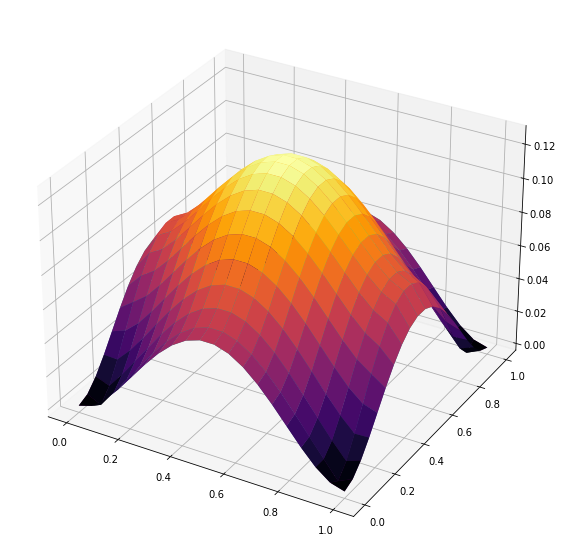

In [19]:
Nx = 20
Ny = 20
tau = 0.025
eps = 0.0001
x = np.linspace(0,1, Nx)
y = np.linspace(0,1, Ny)
u_accuracy = lambda x, y: (x**2)*(1-x)**2 + (y**2)*(1-y)**2
u_accuracy_h = get_function_values(u_accuracy, x, y)
eq = Equation(a=1, f=lambda x,y,t:-4+12*(x+y)-12*(x**2+y**2), X=1, Y=1, T=1, u_0y=lambda y,t:(y**2)*(1-y)**2, u_0y_der = False,\
              u_1y=lambda y,t:(y**2)*(1-y)**2, u_1y_der=False, u_x0=lambda x,t:(x**2)*(1-x)**2, u_x0_der=False,\
              u_x1=lambda x,t:(x**2)*(1-x)**2, u_x1_der = False, u_0=lambda x,y:1+x*0)
u_approximate = eq.solve_iter(Nx, Ny, tau=tau, eps=eps)
print("Error_norm=", error_norm(u_accuracy_h, u_approximate))
fig = plt.figure()
plt.figure(figsize=((10,10)))
ax = plt.axes(projection='3d')
x_tmp, y_tmp = np.meshgrid(x,y)
ax.plot_surface(x_tmp.T,y_tmp.T,u_accuracy_h,cmap ='viridis')
ax.plot_surface(x_tmp.T,y_tmp.T,u_approximate,cmap='inferno')
plt.show()

Error_norm= 0.02341776767881265


<Figure size 432x288 with 0 Axes>

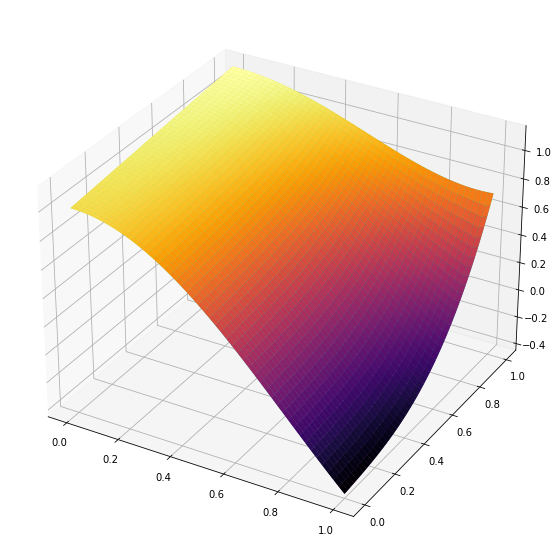

In [26]:
Nx = 50
Ny = 50
Nt = 100
x = np.linspace(0,1, Nx)
y = np.linspace(0,1, Ny)
u_accuracy = lambda x, y: np.cos(2*x) + x**2*y**3 + y*np.sin(3) 
u_accuracy_h = get_function_values(u_accuracy, x, y)
eq = Equation(a=1, f=lambda x,y,t:np.cos(2*x) + 3*y*np.cos(3*t) + 4*t*np.cos(2*x) - 2*y**3 - 6*x**2*y,\
              X=1, Y=1, T=1, u_0y=lambda y,t:t+y*np.sin(3*t), u_0y_der = False,\
              u_1y=lambda y,t:t*np.cos(2)+y**3+y*np.sin(3*t), u_1y_der=False, u_x0=lambda x,t:t*np.cos(2*x), u_x0_der=False,\
              u_x1=lambda x,t:t*np.cos(2*x)+x**2+np.sin(3*t), u_x1_der = False, u_0=lambda x,y:x**2*y**3)
u_approximate = eq.solve_ssp(Nx, Ny, Nt)
print("Error_norm=", error_norm(u_accuracy_h, u_approximate))
fig = plt.figure()
plt.figure(figsize=((10,10)))
ax = plt.axes(projection='3d')
x_tmp, y_tmp = np.meshgrid(x,y)
ax.plot_surface(x_tmp.T,y_tmp.T,u_accuracy_h,cmap ='viridis')
ax.plot_surface(x_tmp.T,y_tmp.T,u_approximate,cmap='inferno')
plt.show()